<a href="https://colab.research.google.com/github/Sinamhd9/Color_transfer/blob/main/color_transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
''' Color Transfer implementation by Sina Mehdinia: Fully vectorized (no for loop) 
Reference paper: Color transfer between images. Erik Reinhard, Michael Ashikhmin, Bruce Gooch, and Peter Shirley.
IEEE Computer Graphics and Applications.21(5), 2001: 34 - 41.
'''
import cv2
import numpy as np
import sys

def BGR_to_RGB(img_BGR):
    '''
    convert image color space BGR to RGB
    '''
    img_RGB = np.zeros_like(img_BGR,dtype=np.float32)
    img_RGB[:,:,0] = img_BGR[:,:,2]
    img_RGB[:,:,1] = img_BGR[:,:,1]
    img_RGB[:,:,2] = img_BGR[:,:,0]
    return img_RGB
def RGB_to_BGR(img_RGB):
    '''
    convert image color space RGB to BGR
    '''
    img_BGR = np.zeros_like(img_RGB,dtype=np.float32)
    img_BGR[:,:,0] = img_RGB[:,:,2]
    img_BGR[:,:,1] = img_RGB[:,:,1]
    img_BGR[:,:,2] = img_RGB[:,:,0]
    return img_BGR

def RGB_to_Lab(img_RGB):
    '''
    convert image color space RGB to Lab
    '''
    img_LMS = np.zeros_like(img_RGB, dtype=np.float32)
    a = np.array([[0.3811,0.5783,0.0402],[0.1967,0.7244,0.0782],[0.0241,0.1288,0.8444]])
    b = np.array([[1/np.sqrt(3),0,0],[0,1/np.sqrt(6),0],[0,0,1/np.sqrt(2)]])
    c = np.array([[1,1,1],[1,1,-2],[1,-1,0]])
    [m,n,k] = np.shape(img_RGB)
    img_LMS = np.matmul(a,(np.transpose(np.reshape(img_RGB, [m*n,k]))))
    img_LMS = np.log10(img_LMS+np.finfo(float).eps)
    img_Lab = np.zeros_like(img_RGB, dtype=np.float32)
    img_Lab = np.matmul(b, np.matmul(c, img_LMS))
    img_Lab = np.reshape(np.transpose(img_Lab), [m,n,k])
    return img_Lab

def Lab_to_RGB(img_Lab):
    '''
    convert image color space Lab to RGB
    '''
    img_LMS = np.zeros_like(img_Lab,dtype=np.float32)
    b2 = np.array([[np.sqrt(3)/3,0,0],[0,np.sqrt(6)/6,0],[0,0,np.sqrt(2)/2]]) 
    c2 = np.array([[1,1,1],[1,1,-1],[1,-2,0]])
    a2 = np.array([[4.4679,-3.5873,0.1193],[-1.2186,2.3809,-0.1624],[0.0497,-0.2439,1.2045]])
    [m,n,k] = np.shape(img_Lab)
    img_LMS = np.matmul(c2,np.matmul(b2,np.transpose(np.reshape(img_Lab,[m*n,k]))))
    img_LMS = 10**img_LMS
    img_RGB = np.zeros_like(img_Lab,dtype=np.float32)
    img_RGB = np.transpose(np.matmul(a2,img_LMS))
    img_RGB = np.reshape(img_RGB,[m,n,k])
    return img_RGB

def RGB_to_CIECAM97s(img_RGB):
    '''
    convert image color space RGB to CIECAM97s
    '''
    img_CIECAM97s = np.zeros_like(img_RGB,dtype=np.float32)
    r = np.array([[2,1,0.05],[1,-1.09,0.09],[0.11,0.11,-0.22]]) 
    [m,n,k] = np.shape(img_RGB)
    img_CIECAM97s = np.matmul(r,(np.transpose(np.reshape(img_RGB,[m*n,k]))))
    return img_CIECAM97s

def CIECAM97s_to_RGB(img_CIECAM97s):
    '''
    convert image color space CIECAM97s to RGB
    '''
    img_RGB = np.zeros_like(img_CIECAM97s,dtype=np.float32)
    r = np.array([[2,1,0.05],[1,-1.09,0.09],[0.11,0.11,-0.22]]) 
    r2 = np.linalg.inv(r)
    [m,n,k] = np.shape(img_CIECAM97s)
    img_RGB = np.transpose(np.matmul(r2,img_CIECAM97s))
    img_RGB = np.reshape(img_RGB,[m,n,k])
    return img_RGB


def color_transfer_in_Lab(img_RGB_source, img_RGB_target):
    print('----- color_transfer_in_Lab -----')
    img_RGB_source = BGR_to_RGB(img_RGB_source)
    img_RGB_target = BGR_to_RGB(img_RGB_target)
    img_LAB_s = RGB_to_Lab(img_RGB_source)
    img_LAB_t = RGB_to_Lab(img_RGB_target)
    mu_s = (np.mean(img_LAB_s,axis=(0,1)))
    st_s = (np.std(img_LAB_s,axis=(0,1))) 
    mu_t = (np.mean(img_LAB_t,axis=(0,1)))
    st_t = (np.std(img_LAB_t,axis=(0,1)))
    img_LAB_s -=  mu_s
    img_LAB_s*= (st_t/st_s)
    img_LAB_s += mu_t
    img_RGB_final = Lab_to_RGB(img_LAB_s)
    img_RGB_final = RGB_to_BGR(img_RGB_final)
    return img_RGB_final

def color_transfer_in_RGB(img_RGB_source, img_RGB_target):
    print('----- color_transfer_in_RGB -----')
    img_RGB_source = BGR_to_RGB(img_RGB_source)
    img_RGB_target = BGR_to_RGB(img_RGB_target)
    mu_s = (np.mean(img_RGB_source,axis=(0,1)))
    st_s = (np.std(img_RGB_source,axis=(0,1))) 
    mu_t = (np.mean(img_RGB_target,axis=(0,1)))
    st_t = (np.std(img_RGB_target,axis=(0,1)))
    img_RGB_source -=  mu_s
    img_RGB_source*= (st_t/st_s)
    img_RGB_source += mu_t
    img_RGB_s_new = RGB_to_BGR(img_RGB_source)
    return img_RGB_s_new


def color_transfer_in_CIECAM97s(img_RGB_source, img_RGB_target):
    print('-----color_transfer_in_CIECAM97s -----')
    img_RGB_source = BGR_to_RGB(img_RGB_source)
    img_RGB_target = BGR_to_RGB(img_RGB_target)
    img_CIECAM97s_s = RGB_to_Lab(img_RGB_source)
    img_CIECAM97s_t = RGB_to_Lab(img_RGB_target)
    mu_s = (np.mean(img_CIECAM97s_s,axis=(0,1)))
    st_s = (np.std(img_CIECAM97s_s,axis=(0,1))) 
    mu_t = (np.mean(img_CIECAM97s_t,axis=(0,1)))
    st_t = (np.std(img_CIECAM97s_t,axis=(0,1)))
    img_CIECAM97s_s -=  mu_s
    img_CIECAM97s_s*= (st_t/st_s)
    img_CIECAM97s_s+= mu_t
    img_RGB_final = Lab_to_RGB(img_CIECAM97s_s)
    img_RGB_final =  RGB_to_BGR(img_RGB_final)
    return img_RGB_final

def color_transfer(img_RGB_source, img_RGB_target, option):
    if option == 'in_RGB':
        img_RGB_new = color_transfer_in_RGB(img_RGB_source, img_RGB_target)
    elif option == 'in_Lab':
        img_RGB_new = color_transfer_in_Lab(img_RGB_source, img_RGB_target)
    elif option == 'in_CIECAM97s':
        img_RGB_new = color_transfer_in_CIECAM97s(img_RGB_source, img_RGB_target)
    return img_RGB_new





----- Source -----


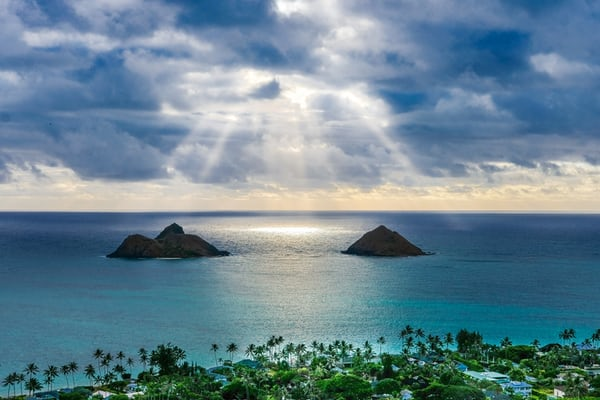

----- Target -----


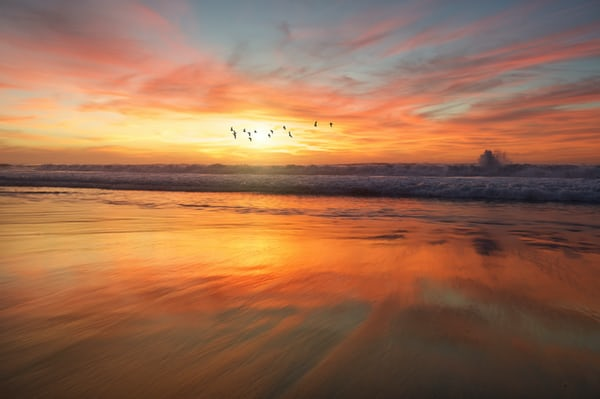

----- color_transfer_in_Lab -----


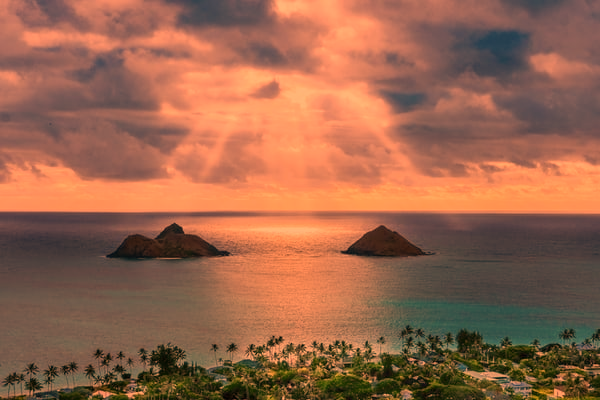

----- color_transfer_in_RGB -----


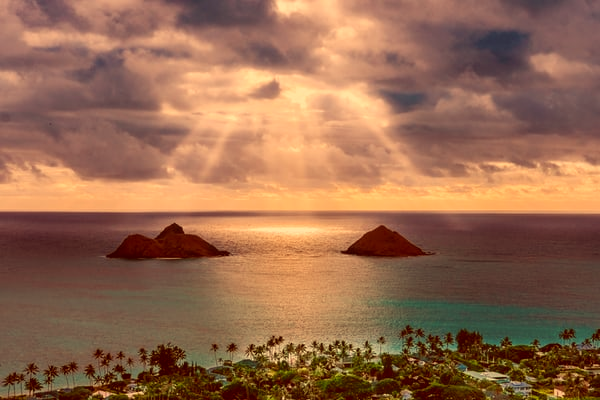

-----color_transfer_in_CIECAM97s -----


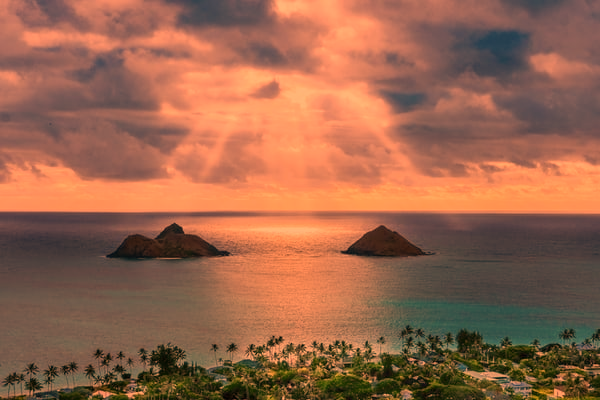

In [4]:
 from google.colab.patches import cv2_imshow

 # Example 
img_RGB_source = cv2.imread('source.jfif', cv2.IMREAD_COLOR)
img_RGB_target = cv2.imread('target.jfif',cv2.IMREAD_COLOR )
print('----- Source -----')
cv2_imshow(img_RGB_source)
print('----- Target -----')

cv2_imshow(img_RGB_target)

img_RGB_new_Lab = color_transfer(img_RGB_source, img_RGB_target, option='in_Lab')
cv2_imshow(img_RGB_new_Lab)

img_RGB_new_RGB = color_transfer(img_RGB_source, img_RGB_target, option='in_RGB')
cv2_imshow(img_RGB_new_RGB)

img_RGB_new_CIECAM97s = color_transfer(img_RGB_source, img_RGB_target, option='in_CIECAM97s')
cv2_imshow(img_RGB_new_CIECAM97s)